# ABOUT THIS NOTEBOOK
## Purpose
This notebook performs residual analysis for the various machine learning models attempted on the data set.    
## Input
'data_set.pickle' generated by 'data_processing.ipynb'.
## Output
Results of residual analysis.
## Tasks Performed
* Load library packages
* Load pickle file
* Split data into train & test sets
    * Train: weeks 1 & 2, Test: week 3
    * Perform feature scaling
* Implement classes & functions for common tasks
    * Fit the algorithm
    * Generate error column
    * Generate residual plot
* Run the following algorithms:
    * Random Forest Regressor
    * K Nearest Neighbors
    * Support Vector Machines
    * Linear Regression
    * Gradient Boosting Regressor
    * Neural Networks

# LOAD LIBRARY PACKAGES

In [1]:
# Import the required library packages
import os
import re
import timeit

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import tensorflow as tf
#import tensorflow.contrib.learn as skflow

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

from six.moves import cPickle as pickle

# Settings for matplotlib, Seaborn
%matplotlib inline
sns.set_style('whitegrid')

# Set font sizes for matplots
plt.rcParams.update({'font.size': 15, 
                     'legend.fontsize': 'medium', 
                     'axes.titlesize': 'medium', 
                     'axes.labelsize': 'medium'})

print 'Read in packages from os, numpy, pandas, matplotlib, seaborn, tensorflow, sklearn & six'

Read in packages from os, numpy, pandas, matplotlib, seaborn, tensorflow, sklearn & six


# LOAD PICKLE FILE

In [2]:
pickle_file = 'data_set.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    pdata_set = save['data_set']
    del save
    print 'Loaded ptrain_set', pdata_set.shape
    
f.close()

Loaded ptrain_set (199584, 55)


In [3]:
pdata_set.columns.values

array(['district_id', 'num_day', 'time_slot', 'week_day', 'demand',
       'demand_t-1', 'demand_t-2', 'demand_t-3', 'supply', 'supply_t-1',
       'supply_t-2', 'supply_t-3', 'gap', 'weather', 'temperature',
       'pollution', 'poi_pc1', 'poi_pc2', 'poi_pc3', 'poi_pc4',
       'poi_cluster', 'tj_lvl1', 'tj_lvl2', 'tj_lvl3', 'tj_lvl4', 'dist_0',
       'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5', 'dist_6',
       'numday_0', 'numday_1', 'numday_2', 'numday_3', 'numday_4', 'ts_0',
       'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7', 'weekday_0',
       'weekday_1', 'weekday_2', 'poi_0', 'poi_1', 'poi_2', 'wthr_0',
       'wthr_1', 'wthr_2', 'wthr_3'], dtype=object)

# SPLIT DATA INTO TRAIN & TEST SETS

## Use weeks 1 & 2 for training, week 3 for test

In [4]:
train_days     = range(1,15)
test_days      = range(15, 22)

X_train     = pdata_set[(pdata_set['num_day'].isin(train_days))]
X_test      = pdata_set[(pdata_set['num_day'].isin(test_days))]

print "Shape of X_train, X_test:", X_train.shape, X_test.shape, "\n\n"

Shape of X_train, X_test: (133056, 55) (66528, 55) 




## Generate scaled features for train & test sets

In [5]:
import warnings
warnings.filterwarnings('ignore')

gap_predictors = ['demand_t-1', 'demand_t-2', 'demand_t-3',
                  'supply_t-1', 'supply_t-2', 'supply_t-3',
                  'poi_pc1', 'poi_pc2',
                  'tj_lvl1', 'tj_lvl2', 'tj_lvl3',
                  'ts_0', 'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7',
                  'pollution', 'temperature',
                  'wthr_0', 'wthr_1', 'wthr_2', 'wthr_3'
                 ]  

gX_train = []
gy_train = []
gX_test  = []
gy_test  = []

# Use StandardScaler to achieve zero mean and unit variance
# Generate two scalers: input and target
input_scaler = StandardScaler().fit(pdata_set[gap_predictors])
target_scaler = StandardScaler().fit(pdata_set['gap'])

# Scale both training & test data
gX_train  = input_scaler.transform(X_train[gap_predictors])
gy_train  = target_scaler.transform(X_train['gap'])

gX_test = input_scaler.transform(X_test[gap_predictors])
gy_test = target_scaler.transform(X_test['gap'])

In [6]:
X_train.columns.values

array(['district_id', 'num_day', 'time_slot', 'week_day', 'demand',
       'demand_t-1', 'demand_t-2', 'demand_t-3', 'supply', 'supply_t-1',
       'supply_t-2', 'supply_t-3', 'gap', 'weather', 'temperature',
       'pollution', 'poi_pc1', 'poi_pc2', 'poi_pc3', 'poi_pc4',
       'poi_cluster', 'tj_lvl1', 'tj_lvl2', 'tj_lvl3', 'tj_lvl4', 'dist_0',
       'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5', 'dist_6',
       'numday_0', 'numday_1', 'numday_2', 'numday_3', 'numday_4', 'ts_0',
       'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7', 'weekday_0',
       'weekday_1', 'weekday_2', 'poi_0', 'poi_1', 'poi_2', 'wthr_0',
       'wthr_1', 'wthr_2', 'wthr_3'], dtype=object)

# IMPLEMENT CLASSES & FUNCTIONS FOR COMMON TASKS

In [24]:
class ResidualPlot(object):
    '''Residual analysis for attempted machine learning algorithms'''
    
    def __init__(self,alg,X,y):
        '''Fit the algorithm to the test data'''
        self.reg = alg.fit(X,y)
        print 'Successfully fit the algorithm to train data.'
        
        self.pred_train = target_scaler.inverse_transform(self.reg.predict(X))
        self.error_train = X_train['gap'] - self.pred_train
        print 'Generated predictions and errors for train data.'
        
        self.residual_df = X_train.copy()
        self.residual_df['predicted_gap'] = self.pred_train
        self.residual_df['residual'] = self.error_train
        print 'Created dataframe with residual column.\n'
   
    def generate_corrmatrix(self):
        '''Generate correlation matrix with residual data'''
        print 'CORRELATION MATRIX - RESIDUAL vs FEATURES'
        print self.residual_df.corr()['residual']
      
    def generate_resplot(self):
        '''Generate residual plot'''
        sns.residplot(self.residual_df['gap'], self.residual_df['predicted_gap'])
        sns.plt.title('Residual Plot - Actual Gap vs Predicted Gap')
          
    def generate_facetplots(self):
        '''Generate facet plots'''
        pdata_set = self.residual_df
        self.plot_set = pdata_set[(pdata_set['district_id'].isin([12, 19, 23]))]
        self._facetplot_gap()
        self._facetplot_time()
        self._facetplot_demand()
        self._facetplot_supply()
        self._facetplot_traffic()
        
    def _facetplot_gap(self):
        g = sns.FacetGrid(self.plot_set, col='district_id')
        g.map(plt.scatter, 'gap', 'residual')
        plt.subplots_adjust(top=0.8)
        g.fig.suptitle('Facet Plot - Gap vs Residual')
        plt.show()
    
    def _facetplot_time(self):
        g = sns.FacetGrid(self.plot_set, col='district_id')
        g.map(plt.scatter, 'time_slot', 'residual')
        plt.subplots_adjust(top=0.8)
        g.fig.suptitle('Facet Plot - Time vs Residual')
        plt.show()
        
    def _facetplot_demand(self):
        g = sns.FacetGrid(self.plot_set, col='district_id')
        g.map(plt.scatter, 'demand_t-1', 'residual')
        plt.subplots_adjust(top=0.8)
        g.fig.suptitle('Facet Plot - Demand vs Residual')
        plt.show()
 
    def _facetplot_supply(self):
        g = sns.FacetGrid(self.plot_set, col='district_id')
        g.map(plt.scatter, 'supply_t-1', 'residual')
        plt.subplots_adjust(top=0.8)
        g.fig.suptitle('Facet Plot - Supply vs Residual')
        plt.show()
        
    def _facetplot_traffic(self):
        g = sns.FacetGrid(self.plot_set, col='district_id')
        g.map(plt.scatter, 'tj_lvl3', 'residual')
        plt.subplots_adjust(top=0.8)
        g.fig.suptitle('Facet Plot - Traffic vs Residual')
        plt.show()
    
    def feature_importances(self):
        '''Use random forest feature importances to find features that may influence residual error'''
    
        predictors = ['dist_0', 'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5', 'dist_6',
                      'wthr_0', 'wthr_1', 'wthr_2', 'wthr_3', 
                      'poi_pc2', 'poi_pc3', 'poi_pc4',
                      'numday_0', 'numday_1', 'numday_2', 'numday_3', 'numday_4', 
                      'weekday_0', 'weekday_1', 'weekday_2',
                      'time_slot', 'week_day'
                     ] 

        # Input Samples and Target Values
        X = self.residual_df[predictors]
        y = self.residual_df['residual']

        # Fit Random Forest Regressor
        # Large n_estimators, small max_depth to avoid overfitting
        alg = RandomForestRegressor(n_jobs=-1, random_state=1, n_estimators=1000, max_depth=20)
        rfr = alg.fit(X, y)

        # Feature importances
        importances = rfr.feature_importances_
        indices = np.argsort(importances)[::-1]
        feature_labels = predictors
    
        print 'FEATURE IMPORTANCES - RESIDUAL vs SELECT FEATURES'
        for f in range(X.shape[1]):
            print("%2d) %-*s %f" % (f + 1, 30, 
                                    feature_labels[indices[f]], 
                                    importances[indices[f]]))

        labels_reordered = [feature_labels[i] for i in indices]
    
        plt.title('Residual Feature Importances')
        plt.bar(range(X.shape[1]), importances[indices], color='lightblue', align='center')
        plt.xticks(range(X.shape[1]), labels_reordered, rotation=90)
        plt.xlim([-1, X.shape[1]])
        plt.tight_layout()
        plt.show()

# LINEAR REGRESSION

Successfully fit the algorithm to train data.
Generated predictions and errors for train data.
Created dataframe with residual column.

CORRELATION MATRIX - RESIDUAL vs FEATURES
district_id      0.008485
num_day         -0.008694
time_slot       -0.018786
week_day        -0.004211
demand           0.137167
demand_t-1      -0.000134
demand_t-2      -0.021769
demand_t-3      -0.000134
supply          -0.011602
supply_t-1      -0.000100
supply_t-2      -0.000100
supply_t-3       0.012591
gap              0.326186
weather          0.004077
temperature     -0.009222
pollution        0.008367
poi_pc1         -0.010893
poi_pc2          0.022819
poi_pc3         -0.007125
poi_pc4          0.011009
poi_cluster      0.006018
tj_lvl1         -0.000165
tj_lvl2         -0.006725
tj_lvl3         -0.005791
tj_lvl4         -0.004507
predicted_gap   -0.000132
residual         1.000000
Name: residual, dtype: float64


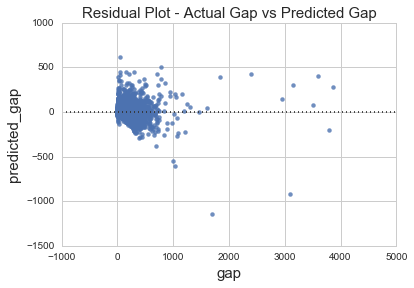

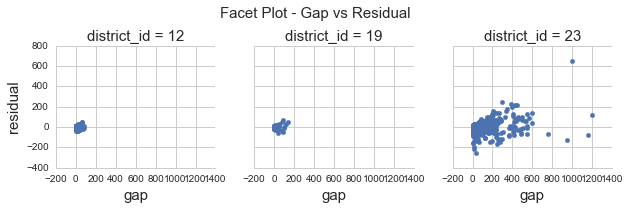

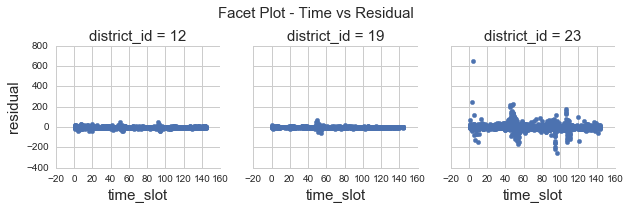

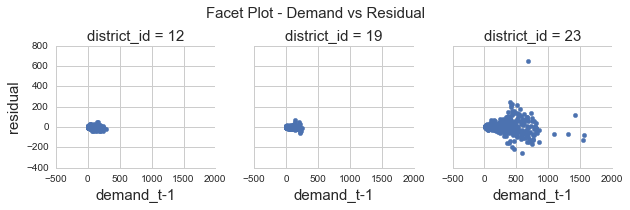

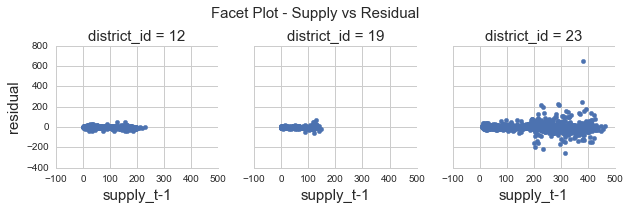

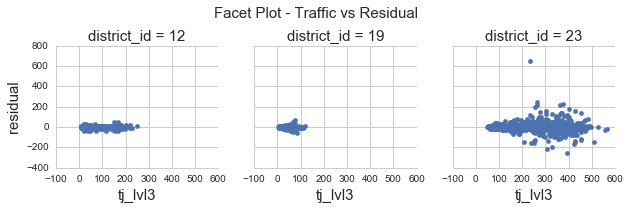

FEATURE IMPORTANCES - RESIDUAL vs SELECT FEATURES
 1) time_slot                      0.343100
 2) week_day                       0.138887
 3) poi_pc2                        0.062438
 4) poi_pc4                        0.060788
 5) numday_3                       0.056093
 6) wthr_0                         0.046797
 7) wthr_1                         0.036207
 8) weekday_1                      0.030647
 9) numday_0                       0.029639
10) poi_pc3                        0.029533
11) numday_2                       0.025217
12) numday_1                       0.024790
13) wthr_2                         0.021827
14) weekday_0                      0.020490
15) weekday_2                      0.013958
16) dist_5                         0.011421
17) wthr_3                         0.011272
18) dist_2                         0.010558
19) dist_4                         0.008245
20) dist_3                         0.007343
21) dist_0                         0.007152
22) dist_1                

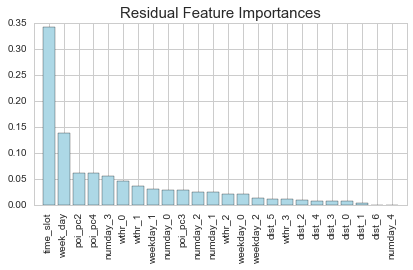

In [25]:
linear_predictors = [0,3,2,4]
alg = LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=True)

linear_regr_residual = ResidualPlot(alg, gX_train[:, linear_predictors], gy_train)
linear_regr_residual.generate_corrmatrix()
linear_regr_residual.generate_resplot()
linear_regr_residual.generate_facetplots()
linear_regr_residual.feature_importances()

# RANDOM FORESTS

In [ ]:
rf_predictors = [0,3,1,5,2,8,4,19]
alg = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12, max_features=1.0, max_leaf_nodes=None, 
                            min_samples_leaf=5, min_samples_split=25, min_weight_fraction_leaf=0.0, n_estimators=300, 
                            n_jobs=-1, oob_score=False, random_state=0, verbose=0, warm_start=False
                           )

random_forests_residual = ResidualPlot(alg, gX_train[:, rf_predictors], gy_train)
random_forests_residual.generate_corrmatrix()
random_forests_residual.generate_resplot()
random_forests_residual.generate_facetplots()
random_forests_residual.feature_importances()

# K NEAREST NEIGHBORS

In [ ]:
knn_predictors = [0,3,1,5,2,8,4,19]
alg = KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean', metric_params=None, n_jobs=-1, 
                          n_neighbors=7, p=2, weights='uniform'
                         )

knn_residual = ResidualPlot(alg, gX_train[:, knn_predictors], gy_train)
knn_residual.generate_corrmatrix()
knn_residual.generate_resplot()
knn_residual.generate_facetplots()
knn_residual.feature_importances()

# SUPPORT VECTOR MACHINES

In [ ]:
svm_predictors = [0,3,1,4,2,5]
alg = SVR(C=1.0, cache_size=1000, coef0=0.0, degree=3, epsilon=0.1, gamma='auto', kernel='linear', max_iter=-1, 
          shrinking=True, tol=0.001, verbose=False
         )

svm_residual = ResidualPlot(alg, gX_train[:, svm_predictors], gy_train)
svm_residual.generate_corrmatrix()
svm_residual.generate_resplot()
svm_residual.generate_facetplots()
svm_residual.feature_importances()

# GRADIENT BOOSTED TREES

In [ ]:
gbr_predictors = [0,3,2,1,20,9,5,19]
alg = GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.15, loss='ls', max_depth=5, max_features=None, 
                                max_leaf_nodes=None, min_samples_leaf=3, min_samples_split=8, min_weight_fraction_leaf=0.0, 
                                n_estimators=100, presort='auto', random_state=None, subsample=0.8, verbose=0, warm_start=False
                               )

gbr_residual = ResidualPlot(alg, gX_train[:, gbr_predictors], gy_train)
gbr_residual.generate_corrmatrix()
gbr_residual.generate_resplot()
gbr_residual.generate_facetplots()
gbr_residual.feature_importances()

# NEURAL NETS

In [ ]:
nn_predictors = [0,3,1,5,2,8,4,19]

# Set up optimizer, regressor
learning_rate=0.01 
hidden_units=[8] 
dropout=0.3 
steps=50000 
batch_size=3000

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
alg = skflow.DNNRegressor(hidden_units=hidden_units, optimizer=optimizer, dropout=float(dropout))

nn_residual = ResidualPlot(alg, gX_train[:, nn_predictors], gy_train)
nn_residual.generate_corrmatrix()
nn_residual.generate_resplot()
nn_residual.generate_facetplots()
nn_residual.feature_importances()